In [1]:
import pandas as pd
import json
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import pickle
from DataLoader import MolDataset
import torch
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import MoleculeNet
from torch.optim import AdamW
import numpy as np
from scipy.spatial import distance
from PyPDF2 import PdfReader, PdfWriter, PdfMerger
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import letter

In [2]:
from Dual_channel_gin_extend_expl import GNNModel

In [3]:
'''
Change result dict when you run new experiments 

folder - Enter list of folders to check, each folder will be traversed to check if file exists in folder
seed
arch
size_reg
dataset

**IMPORTANT** : Change EXPT_BASE_NAME if you update the folder name to where your results are stored
'''

date_tag = '0830'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CONFIG_LOCATION = 'to_plot_configs.json'
PLOT_LOCATION = 'all_plots_sreg0.pdf'


with open(CONFIG_LOCATION,'r') as file:
    results_dict = json.load(file)
base_path = '/nfs/stak/users/kokatea/ondemand/data/sys/myjobs/projects/default'
#base_path = '../Cluster_JOBS/Size_Reg/'

dataset_dict = {'MUTAG':'Mutagenicity','BBBP':'BBBP','HERG':'hERG'}

#def return_expt_base_name(seed,arch,size_reg,dataset):
#
#    EXPT_BASE_NAME = f'EXPT-32A{dataset}-{seed}-{arch}-{size_reg}'
#    return EXPT_BASE_NAME

def return_expt_base_name(seed,arch,channel,dataset):

    EXPT_BASE_NAME = f'EXPT-32A{dataset}-{seed}-{arch}-{channel}'
    return EXPT_BASE_NAME

Finished : BBBP - GCNConv - Seed : 2 - Channel  - Size Reg 0 - LR 0.0001 - Message Passing : 2 - Hidden : 16 - Entropy Reg : 0.2
Finished : BBBP - GATConv - Seed : 2 - Channel  - Size Reg 0 - LR 0.0001 - Message Passing : 2 - Hidden : 16 - Entropy Reg : 0.2
Finished : BBBP - GINConv - Seed : 3 - Channel  - Size Reg 0 - LR 0.0001 - Message Passing : 2 - Hidden : 16 - Entropy Reg : 0.2
Finished : BBBP - GCNConv - Seed : 3 - Channel  - Size Reg 0 - LR 0.0001 - Message Passing : 2 - Hidden : 16 - Entropy Reg : 0.2
Finished : BBBP - GATConv - Seed : 3 - Channel  - Size Reg 0 - LR 0.0001 - Message Passing : 2 - Hidden : 16 - Entropy Reg : 0.2
Finished : Mutagenicity - GINConv - Seed : 2 - Channel  - Size Reg 0 - LR 0.0001 - Message Passing : 2 - Hidden : 16 - Entropy Reg : 0.2
Finished : Mutagenicity - GCNConv - Seed : 2 - Channel  - Size Reg 0 - LR 0.0001 - Message Passing : 2 - Hidden : 16 - Entropy Reg : 0.2
Finished : Mutagenicity - GATConv - Seed : 2 - Channel  - Size Reg 0 - LR 0.0001 

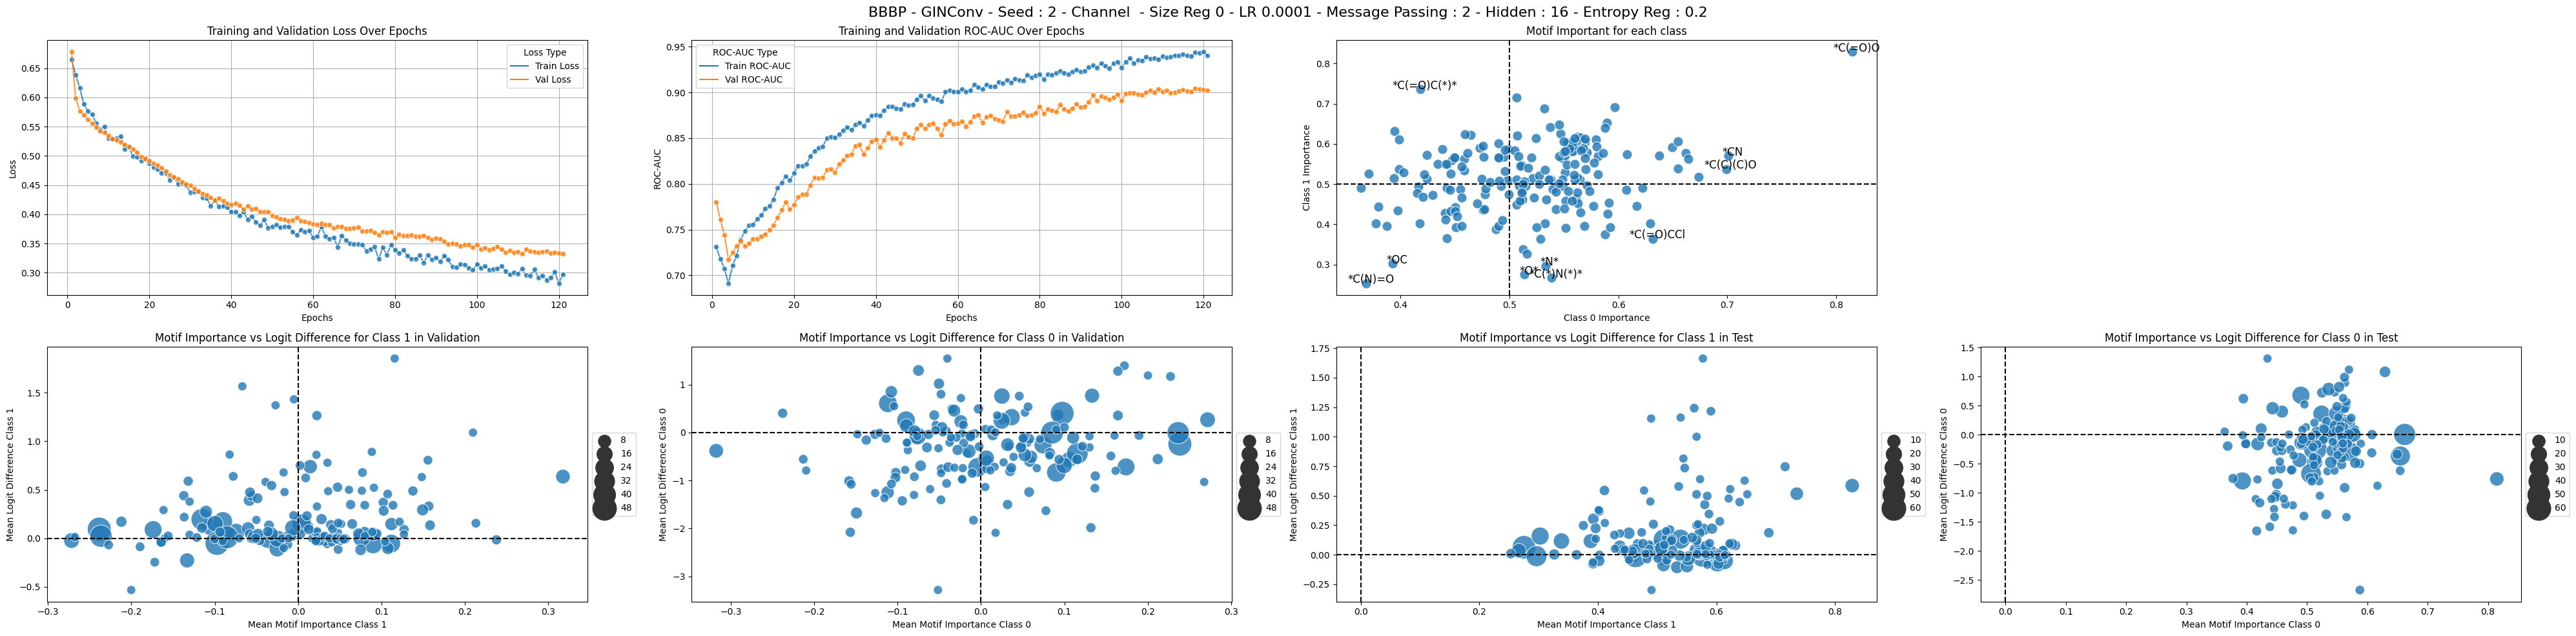

In [4]:
result_list = []


for k,v in results_dict.items():
    
    dataset = v['dataset']
    seed = v['seed']
    arch = v['layer_type']
    folder = v['folder']
    size_reg = v['size_reg']
    channel = ''#v['model_type']
    
    if size_reg == 0.0:
        size_reg = 0
    
    training_data = MolDataset(root=".", split='training',csv_file=f"{dataset_dict[dataset]}.csv")
    with open(f'./dictionary/{dataset_dict[dataset]}_graph_lookup_{date_tag}.pickle', 'rb') as file:
        lookup = pickle.load(file)
    with open(f'dictionary/{dataset_dict[dataset]}_motif_list_{date_tag}.pickle', 'rb') as file:
        motif_list = list(pickle.load(file))
    with open(f'dictionary/{dataset_dict[dataset]}_test_graph_lookup_{date_tag}.pickle', 'rb') as file:
        # Serialize and save the object to the file
        test_data_lookup = pickle.load(file)
    
    if channel == 'SingleParam':
        params_motif_x_class = torch.full((len(motif_list), 1), 0.0)
    else:
        params_motif_x_class = torch.full((len(motif_list), 2), 0.0)
    
                    
    found = True
    #get folder name
    EXPT_NAME = return_expt_base_name(seed,arch,size_reg,dataset)
    # EXPT_NAME = return_expt_base_name(seed,arch,channel,dataset)

    #check if EXPT_NAME exists in folder
    EXPT_LOCATION = base_path+f'/{folder}/{EXPT_NAME}'
    
    
    
    if os.path.exists(EXPT_LOCATION):

        #TRY loading the json file
        try:
            with open(EXPT_LOCATION+f'/{dataset_dict[dataset]}config.json') as file:
                config = json.load(file)
        except Exception as e:
            print(f"error when trying to load config Json : {e}")
            found = False

        try:
            
            
            #Recreate loss metrics
            try:
                train_metrics = pd.read_csv(EXPT_LOCATION+f'/explainer/{dataset_dict[dataset]}.csv')
            except Exception as e:
                print(f"error when trying to load train metrics: {e}")
                found = False
            
            train_metrics['Train Loss'] = train_metrics['Train Loss'] - train_metrics['Mask Loss']
            
            
            loss_long = pd.melt(train_metrics, id_vars='Epoch', value_vars=['Train Loss', 'Val Loss'],var_name='loss_type', value_name='loss')
            acc_long = pd.melt(train_metrics, id_vars='Epoch', value_vars=['Train ROC-AUC', 'Val ROC-AUC'],var_name='auroc_type', value_name='auroc')
            
            
            imp_vs_logit_diff_val = pd.read_csv(EXPT_LOCATION+f'/{dataset_dict[dataset]}_explanation_result_with_validation.csv')
                        
            imp_vs_logit_diff_val['logit_diff_class_1'] = imp_vs_logit_diff_val['new_logit_class_1'] - imp_vs_logit_diff_val['original_logit_class_1']
            imp_vs_logit_diff_val['logit_diff_class_0'] = imp_vs_logit_diff_val['new_logit_class_0'] - imp_vs_logit_diff_val['original_logit_class_0']
            imp_vs_logit_diff_val['sigmoid_importance_for_class_1_temp'] = imp_vs_logit_diff_val['sigmoid_importance_for_class_1']-imp_vs_logit_diff_val['sigmoid_importance_for_class_0']
            imp_vs_logit_diff_val['sigmoid_importance_for_class_0'] = imp_vs_logit_diff_val['sigmoid_importance_for_class_0']-imp_vs_logit_diff_val['sigmoid_importance_for_class_1']
            imp_vs_logit_diff_val['sigmoid_importance_for_class_1'] = imp_vs_logit_diff_val['sigmoid_importance_for_class_1_temp']
            imp_vs_logit_diff_val.drop('sigmoid_importance_for_class_1_temp', axis=1, inplace = True)
            
            if channel == 'SingleParam':
                imp_vs_logit_diff_val['sigmoid_importance_for_class_1'] = imp_vs_logit_diff_val['sigmoid_importance_for_class_0']
                imp_vs_logit_diff_val['sigmoid_importance_for_class_0'] = 1-imp_vs_logit_diff_val['sigmoid_importance_for_class_1']
            
            imp_vs_logit_diff_val = imp_vs_logit_diff_val.groupby('motif_id').agg(
                                            Mean_Logit_Difference_Class_1=('logit_diff_class_1', 'mean'),
                                            Mean_Logit_Difference_Class_0=('logit_diff_class_0', 'mean'),
                                            Mean_Motif_Importance_Class_1=('sigmoid_importance_for_class_1', 'mean'),
                                            Mean_Motif_Importance_Class_0=('sigmoid_importance_for_class_0', 'mean'),
                                            Count_of_Graphs_where_Motif_Found=('motif_id', 'count')
                                        ).reset_index()
            
            imp_vs_logit_diff_val = imp_vs_logit_diff_val.rename(columns = {'Mean_Logit_Difference_Class_1' : 'Mean Logit Difference Class 1',
                                                                    'Mean_Logit_Difference_Class_0' : 'Mean Logit Difference Class 0',
                                                                    'Mean_Motif_Importance_Class_1':'Mean Motif Importance Class 1',
                                                                    'Mean_Motif_Importance_Class_0':'Mean Motif Importance Class 0',
                                                                    'Count_of_Graphs_where_Motif_Found':'Count of Graphs where Motif Found'})
            
            imp_vs_logit_diff_test = pd.read_csv(EXPT_LOCATION+f'/{dataset_dict[dataset]}_explanation_result_with_test.csv')
            imp_vs_logit_diff_test['logit_diff_class_1'] = imp_vs_logit_diff_test['new_logit_class_1'] - imp_vs_logit_diff_test['original_logit_class_1']
            imp_vs_logit_diff_test['logit_diff_class_0'] = imp_vs_logit_diff_test['new_logit_class_0'] - imp_vs_logit_diff_test['original_logit_class_0']
            
            if channel == 'SingleParam':
                imp_vs_logit_diff_test['sigmoid_importance_for_class_1'] = imp_vs_logit_diff_test['sigmoid_importance_for_class_0']
                imp_vs_logit_diff_test['sigmoid_importance_for_class_0'] = 1-imp_vs_logit_diff_test['sigmoid_importance_for_class_1']
            
            imp_vs_logit_diff_test = imp_vs_logit_diff_test.groupby('motif_id').agg(
                                            Mean_Logit_Difference_Class_1=('logit_diff_class_1', 'mean'),
                                            Mean_Logit_Difference_Class_0=('logit_diff_class_0', 'mean'),
                                            Mean_Motif_Importance_Class_1=('sigmoid_importance_for_class_1', 'mean'),
                                            Mean_Motif_Importance_Class_0=('sigmoid_importance_for_class_0', 'mean'),
                                            Count_of_Graphs_where_Motif_Found=('motif_id', 'count')
                                        ).reset_index()
            
            imp_vs_logit_diff_test = imp_vs_logit_diff_test.rename(columns = {'Mean_Logit_Difference_Class_1' : 'Mean Logit Difference Class 1',
                                                                    'Mean_Logit_Difference_Class_0' : 'Mean Logit Difference Class 0',
                                                                    'Mean_Motif_Importance_Class_1':'Mean Motif Importance Class 1',
                                                                    'Mean_Motif_Importance_Class_0':'Mean Motif Importance Class 0',
                                                                    'Count_of_Graphs_where_Motif_Found':'Count of Graphs where Motif Found'})
            
            
            model = GNNModel(input_dim = training_data.num_features, 
                             hidden_channels = config["hidden"], 
                             output_dim = training_data.num_classes, 
                             num_layers = config["num_mp_layers"],
                             use_explainer=True,
                             motif_params = params_motif_x_class,
                             lookup = lookup,
                             layer_type = config["layer_type"],
                             test_lookup = test_data_lookup)

            model.to(device)
            model_state = torch.load(EXPT_LOCATION + f'/explainer/{dataset_dict[dataset]}_1weighted_best_model.pth')
            model.load_state_dict(model_state)

            # Convert the tensor to numpy for plotting
            param_numpy = model.motif_params.sigmoid().cpu().detach().numpy()
            
            if channel == 'SingleParam':
                plot_imp_scores = pd.DataFrame({'Class 0 Importance': 1-param_numpy[:, 0], 'Class 1 Importance': param_numpy[:, 0]})
            else:
                plot_imp_scores = pd.DataFrame({'Class 0 Importance': param_numpy[:, 0], 'Class 1 Importance': param_numpy[:, 1]})
            #plot_imp_scores['Class 0 Importance'] = plot_imp_scores['Class 0 Importance'].apply(lambda x: 1/(1 + np.exp(-x)))
            #plot_imp_scores['Class 1 Importance'] = plot_imp_scores['Class 1 Importance'].apply(lambda x: 1/(1 + np.exp(-x)))
            
            
            #imp_plot.set_title('Motif Class Importance')
            #plt.show()

        except Exception as e:
            print(f"error when trying to load model : {e}")
            found = False

        fig, axes = plt.subplots(2, 4, figsize=(40,10))

        # Display the images
        sns.lineplot(data=loss_long, x='Epoch', y='loss', hue='loss_type', marker='o', ax = axes[0,0], alpha=0.8)
        # Customize the plot
        axes[0,0].set_title('Training and Validation Loss Over Epochs')
        axes[0,0].set_xlabel('Epochs')
        axes[0,0].set_ylabel('Loss')
        axes[0,0].legend(title='Loss Type')
        axes[0,0].grid()
                            
        sns.lineplot(data=acc_long, x='Epoch', y='auroc', hue='auroc_type', marker='o', ax = axes[0,1], alpha=0.8)
        # Customize the plot
        axes[0,1].set_title('Training and Validation ROC-AUC Over Epochs')
        axes[0,1].set_xlabel('Epochs')
        axes[0,1].set_ylabel('ROC-AUC')
        axes[0,1].legend(title='ROC-AUC Type')
        axes[0,1].grid()

        
    
        sns.scatterplot(data=plot_imp_scores, x="Class 0 Importance", y="Class 1 Importance",ax=axes[0,2],alpha=0.8,s=120)
        axes[0,2].set_title('Motif Important for each class')  # Optional title for the seaborn plot
        axes[0,2].axhline(0.5, color='black', linestyle='--')  # Horizontal line
        axes[0,2].axvline(0.5, color='black', linestyle='--')  # Vertical line
        
        
        if channel != 'SingleParam':
            
            mean = np.mean(param_numpy, axis=0)
            cov_matrix = np.cov(param_numpy.T)  # Use transpose to get the right shape
        
            if np.linalg.det(cov_matrix) != 0.0:
                # cov_matrix = np.cov(param_numpy.T)
                y_offset = np.random.uniform(-5, 5)
                inv_cov_matrix = np.linalg.inv(cov_matrix)

                mahalanobis_distances = [
                    distance.mahalanobis(point, mean, inv_cov_matrix) for point in param_numpy
                ]
                divergent_indices = np.argsort(mahalanobis_distances)[-10:]

                for i in divergent_indices:
                    axes[0,2].annotate(motif_list[i], (param_numpy[i, 0], param_numpy[i, 1]), textcoords="offset points", xytext=(5, 5+ y_offset), ha='center',fontsize='large')

        axes[0, 3].axis('off')
        
        scatter_0 = sns.scatterplot(data=imp_vs_logit_diff_val, x="Mean Motif Importance Class 1", y="Mean Logit Difference Class 1",size='Count of Graphs where Motif Found',sizes=(100, 700),ax=axes[1,0], alpha=0.8)
        handles, labels = scatter_0.get_legend_handles_labels()
        axes[1,0].legend(handles, labels, loc='center left', ncol=1, bbox_to_anchor=(1.0, 0.5))
        axes[1,0].set_title('Motif Importance vs Logit Difference for Class 1 in Validation')  # Optional title for the seaborn plot
        axes[1,0].axhline(0, color='black', linestyle='--')  # Horizontal line
        axes[1,0].axvline(0, color='black', linestyle='--')  # Vertical line
        
        
        scatter_1 = sns.scatterplot(data=imp_vs_logit_diff_val, x="Mean Motif Importance Class 0", y="Mean Logit Difference Class 0",size='Count of Graphs where Motif Found',sizes=(100, 700),alpha=0.8,ax=axes[1,1])
        handles, labels = scatter_1.get_legend_handles_labels()
        axes[1,1].legend(handles, labels, loc='center left', ncol=1, bbox_to_anchor=(1.0, 0.5))
        axes[1,1].set_title('Motif Importance vs Logit Difference for Class 0 in Validation')  # Optional title for the seaborn plot
        axes[1,1].axhline(0, color='black', linestyle='--')  # Horizontal line
        axes[1,1].axvline(0, color='black', linestyle='--')  # Vertical line
        
        scatter_2 = sns.scatterplot(data=imp_vs_logit_diff_test, x="Mean Motif Importance Class 1", y="Mean Logit Difference Class 1",size='Count of Graphs where Motif Found',sizes=(100, 700),alpha=0.8,ax=axes[1,2])
        handles, labels = scatter_2.get_legend_handles_labels()
        axes[1,2].legend(handles, labels, loc='center left', ncol=1, bbox_to_anchor=(1.0, 0.5))
        axes[1,2].set_title('Motif Importance vs Logit Difference for Class 1 in Test')  # Optional title for the seaborn plot
        axes[1,2].axhline(0, color='black', linestyle='--')  # Horizontal line
        axes[1,2].axvline(0, color='black', linestyle='--')  # Vertical line
        
        
        scatter_3 = sns.scatterplot(data=imp_vs_logit_diff_test, x="Mean Motif Importance Class 0", y="Mean Logit Difference Class 0",size='Count of Graphs where Motif Found',sizes=(100, 700),alpha=0.8,ax=axes[1,3])
        handles, labels = scatter_3.get_legend_handles_labels()
        axes[1,3].legend(handles, labels, loc='center left', ncol=1, bbox_to_anchor=(1.0, 0.5))
        axes[1,3].set_title('Motif Importance vs Logit Difference for Class 0 in Test')  # Optional title for the seaborn plot
        axes[1,3].axhline(0, color='black', linestyle='--')  # Horizontal line
        axes[1,3].axvline(0, color='black', linestyle='--')  # Vertical line
        
        fig.suptitle(f'{dataset_dict[dataset]} - {arch} - Seed : {seed} - Channel {channel} - Size Reg {size_reg} - LR {config["lr"]} - Message Passing : {config["num_mp_layers"]} - Hidden : {config["hidden"]} - Entropy Reg : {config["ent_reg"]}', fontsize=16)
        
        plt.tight_layout()
    
    else:
        print(f'Expt does not exist at Path : {EXPT_LOCATION}')
        found = False  

    if found:
        if not os.path.exists(PLOT_LOCATION):
            fig.savefig(PLOT_LOCATION, bbox_inches='tight')
        else:
            fig.savefig("temp.pdf", bbox_inches='tight')

            plt.close(fig)

            with open(PLOT_LOCATION, 'rb') as existing_file, open('temp.pdf', 'rb') as temp_file:
                existing_pdf = PdfReader(existing_file)
                temp_pdf = PdfReader(temp_file)

                # Create a writer object
                pdf_writer = PdfWriter()

                # Add all pages from the existing PDF
                for page in existing_pdf.pages:
                    pdf_writer.add_page(page)

                # Add all pages from the new PDF (temp.pdf)
                for page in temp_pdf.pages:
                    pdf_writer.add_page(page)

                # Save the updated PDF back to all_plots.pdf
                with open(PLOT_LOCATION, 'wb') as output_file:
                    pdf_writer.write(output_file)

            os.remove('temp.pdf')
            
            print(f'Finished : {dataset_dict[dataset]} - {arch} - Seed : {seed} - Channel {channel} - Size Reg {size_reg} - LR {config["lr"]} - Message Passing : {config["num_mp_layers"]} - Hidden : {config["hidden"]} - Entropy Reg : {config["ent_reg"]}')

        #Try loading the model for importance scores
    else:
        print(f'Expt does not exist at Path : {EXPT_LOCATION}')
        found = False